# Project: Image Classifcation and Regression MVA - CentraleSupélec

### AURIAU Vincent

### 1.Sending your answers

### 2. Getting Started

### 3. Simple Classification

In [2]:
# Given functions to draw shapes

import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

#### Example of a drawn rectangle:

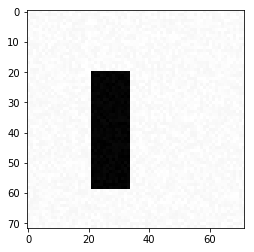

In [3]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

#### Example of a drawn circle:

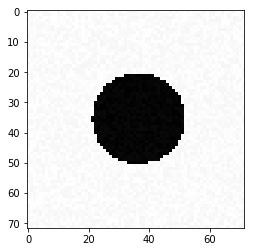

In [4]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

#### Example of a drawn triangle with a high noise:

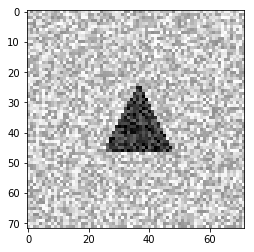

In [5]:
[im, v] = generate_a_triangle(200, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

In [6]:
# Given functions to create the datasets

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [7]:
[X_train, Y_train] = generate_dataset_classification(300, 20) # Training Set creation
[X_test, Y_test] = generate_dataset_classification(300, 20) # Testing set creation

Creating data:
0
100
200
Creating data:
0
100
200


In [8]:
from keras.utils import np_utils
#Transforming Data 

Y_train_cat = np_utils.to_categorical(Y_train)
Y_test_cat = np_utils.to_categorical(Y_test)

print(Y_train[0])
print(Y_train_cat[0])

1.0
[0. 1. 0.]


In [9]:
# import needed keras functions

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import optimizers

#### Linear Classifier using the SGD optimizer:

In [10]:
# First linear classifier using the SGD Optimizer

model_linear = Sequential()
model_linear.add(Dense(3, input_dim=len(X_train[0]), activation='sigmoid'))

sgd = optimizers.SGD(lr=0.01, decay=0, momentum=0, nesterov=False)

model_linear.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])
model_linear.fit(X_train, Y_train_cat, epochs=100, validation_data=(X_test, Y_test_cat))

Train on 300 samples, validate on 300 samples
Epoch 1/100
300/300 [==============================] - 3s 9ms/step - loss: 0.2322 - acc: 0.3700 - val_loss: 0.2013 - val_acc: 0.5833
Epoch 2/100
300/300 [==============================] - 0s 311us/step - loss: 0.2007 - acc: 0.5133 - val_loss: 0.1850 - val_acc: 0.6900
Epoch 3/100
300/300 [==============================] - 0s 276us/step - loss: 0.1803 - acc: 0.6567 - val_loss: 0.1665 - val_acc: 0.7233
Epoch 4/100
300/300 [==============================] - 0s 193us/step - loss: 0.1729 - acc: 0.6700 - val_loss: 0.1652 - val_acc: 0.6000
Epoch 5/100
300/300 [==============================] - 0s 283us/step - loss: 0.1667 - acc: 0.6533 - val_loss: 0.1897 - val_acc: 0.5267
Epoch 6/100
300/300 [==============================] - 0s 245us/step - loss: 0.1599 - acc: 0.6933 - val_loss: 0.1745 - val_acc: 0.5700
Epoch 7/100
300/300 [==============================] - 0s 236us/step - loss: 0.1498 - acc: 0.7367 - val_loss: 0.1367 - val_acc: 0.7633
Epoch 8/100

Epoch 61/100
300/300 [==============================] - 0s 233us/step - loss: 0.0528 - acc: 0.9633 - val_loss: 0.0581 - val_acc: 0.8967
Epoch 62/100
300/300 [==============================] - 0s 230us/step - loss: 0.0527 - acc: 0.9500 - val_loss: 0.0591 - val_acc: 0.9400
Epoch 63/100
300/300 [==============================] - 0s 221us/step - loss: 0.0543 - acc: 0.9600 - val_loss: 0.0503 - val_acc: 0.9300
Epoch 64/100
300/300 [==============================] - 0s 217us/step - loss: 0.0509 - acc: 0.9667 - val_loss: 0.0481 - val_acc: 0.9967
Epoch 65/100
300/300 [==============================] - 0s 277us/step - loss: 0.0523 - acc: 0.9700 - val_loss: 0.0499 - val_acc: 0.9300
Epoch 66/100
300/300 [==============================] - 0s 209us/step - loss: 0.0505 - acc: 0.9633 - val_loss: 0.0511 - val_acc: 0.9833
Epoch 67/100
300/300 [==============================] - 0s 178us/step - loss: 0.0513 - acc: 0.9633 - val_loss: 0.0490 - val_acc: 0.9300
Epoch 68/100
300/300 [==========================

It's converging well on the training set

#### Linear Classifier using the Adam Optimizer:

In [13]:
# Second linear classifier using the adam optimizer

model_linear_2 = Sequential()
model_linear_2.add(Dense(3, input_dim=len(X_train[0]), activation='sigmoid'))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_linear_2.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
model_linear_2.fit(X_train, Y_train_cat, epochs=100, validation_data=(X_test, Y_test_cat))

Train on 300 samples, validate on 300 samples
Epoch 1/100
300/300 [==============================] - 1s 3ms/step - loss: 0.2950 - acc: 0.3200 - val_loss: 0.2734 - val_acc: 0.3367
Epoch 2/100
300/300 [==============================] - 0s 261us/step - loss: 0.2329 - acc: 0.4300 - val_loss: 0.2155 - val_acc: 0.4500
Epoch 3/100
300/300 [==============================] - 0s 280us/step - loss: 0.2084 - acc: 0.4567 - val_loss: 0.2161 - val_acc: 0.4567
Epoch 4/100
300/300 [==============================] - 0s 227us/step - loss: 0.2033 - acc: 0.5033 - val_loss: 0.2015 - val_acc: 0.4733
Epoch 5/100
300/300 [==============================] - 0s 210us/step - loss: 0.1856 - acc: 0.5833 - val_loss: 0.1880 - val_acc: 0.5233
Epoch 6/100
300/300 [==============================] - 0s 227us/step - loss: 0.1636 - acc: 0.6533 - val_loss: 0.1649 - val_acc: 0.6500
Epoch 7/100
300/300 [==============================] - 0s 197us/step - loss: 0.1495 - acc: 0.6967 - val_loss: 0.1611 - val_acc: 0.6067
Epoch 8/100

Epoch 61/100
300/300 [==============================] - 0s 200us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 62/100
300/300 [==============================] - 0s 193us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 63/100
300/300 [==============================] - 0s 266us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 64/100
300/300 [==============================] - 0s 289us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 65/100
300/300 [==============================] - 0s 267us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 66/100
300/300 [==============================] - 0s 330us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 67/100
300/300 [==============================] - 0s 323us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 68/100
300/300 [==========================

With this optimizer, the network converges faster to 100% accuracy on the training set.
We can try a deeper network that wil be sure to converge and not stay stuck in a local minimum

#### Fully connected two layers classifier using the adam optimizer

In [12]:
# Using this model, we can see that the networks converge always towards a state close to 100% accuracy on the training set (and
# also on the testing set) and does not stuck in an intermediate local minimum

two_layers_model = Sequential()
two_layers_model.add(Dense(100, input_dim=len(X_train[0]), activation='sigmoid'))
two_layers_model.add(Dense(3, activation='softmax'))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
two_layers_model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
two_layers_model.fit(X_train, Y_train_cat, epochs=50, validation_data=(X_test, Y_test_cat))

Train on 300 samples, validate on 300 samples
Epoch 1/50
300/300 [==============================] - 2s 6ms/step - loss: 0.2727 - acc: 0.4367 - val_loss: 0.2458 - val_acc: 0.5100
Epoch 2/50
300/300 [==============================] - 0s 1ms/step - loss: 0.2394 - acc: 0.5967 - val_loss: 0.2220 - val_acc: 0.6567
Epoch 3/50
300/300 [==============================] - 0s 1ms/step - loss: 0.2237 - acc: 0.6333 - val_loss: 0.2115 - val_acc: 0.6733
Epoch 4/50
300/300 [==============================] - 0s 1ms/step - loss: 0.2152 - acc: 0.6500 - val_loss: 0.2051 - val_acc: 0.6633
Epoch 5/50
300/300 [==============================] - 1s 2ms/step - loss: 0.2109 - acc: 0.6533 - val_loss: 0.2020 - val_acc: 0.6633
Epoch 6/50
300/300 [==============================] - 1s 3ms/step - loss: 0.2077 - acc: 0.6500 - val_loss: 0.1968 - val_acc: 0.6733
Epoch 7/50
300/300 [==============================] - 1s 2ms/step - loss: 0.2042 - acc: 0.6533 - val_loss: 0.1937 - val_acc: 0.6733
Epoch 8/50
300/300 [==========

### 4. Visualization of the solution

We want to visualize the weights of the linear classifiers

In [14]:
weights = model_linear_2.get_weights()
print(weights[0].shape)
print(weights[1].shape)

matrix = weights[0]

col_1 = matrix[:, 0]
col_2 = matrix[:, 1]
col_3 = matrix[:, 2]

(5184, 3)
(3,)


Visualization of the weights for the rectangle class

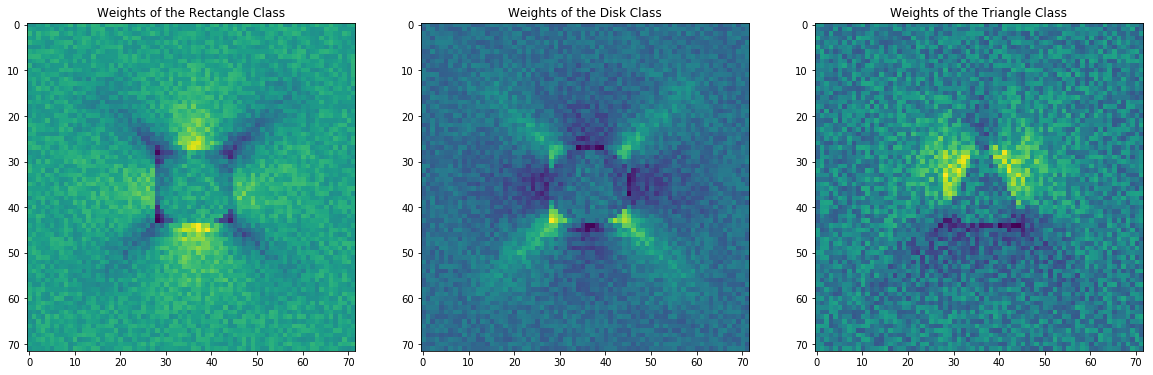

In [15]:
im_1 = col_1.reshape(int(col_1.shape[0]**0.5), int(col_1.shape[0]**0.5))
im_2 = col_2.reshape(int(col_2.shape[0]**0.5), int(col_2.shape[0]**0.5))
im_3 = col_3.reshape(int(col_3.shape[0]**0.5), int(col_3.shape[0]**0.5))

plt.subplots(3, 1, figsize=(20, 20))

plt.subplot(131)
plt.title('Weights of the Rectangle Class')
plt.imshow(im_1)

plt.subplot(132)
plt.title('Weights of the Disk Class')
plt.imshow(im_2)

plt.subplot(133)
plt.title('Weights of the Triangle Class')
plt.imshow(im_3)

plt.show()

We can see that for the rectangle class, the weight are bigger for the vertices of the rectangle which are a specificity of this class.

On the contrary, the weights for the triangle class takes into account the vertices of the triangle (different from the ones of a rectangle), and we can see negative weights that are supposed to make a distinction between a triangle and a circle.7

The weights of the disk class are interesting: we can see that the negatives weights are 'rejecting' rectangle and triangle - like shapes. Thus the big weights are for the pixels that are not supposed to be in a triangle or a rectangle.

### 5. A More Difficult Classification Problem

In [ ]:
# Creating the training Data for the new classification problem

[X_train_2, Y_train_2] = generate_dataset_classification(300, 20, True)
Y_train_cat_2 = np_utils.to_categorical(Y_train_2)

Creating data:
0
100
200


#### 5.1 Classification with the linear classifier

In [ ]:
model_2 = Sequential()
# model_2.add(Dense(100, input_dim=len(X_train[0]), activation='sigmoid'))
model_2.add(Dense(3, activation='softmax'))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_2.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
model_2.fit(X_train_2, Y_train_cat_2, epochs=100)

Epoch 1/100
300/300 [==============================] - 17s 58ms/step - loss: 0.4163 - acc: 0.3100
Epoch 2/100
300/300 [==============================] - 1s 5ms/step - loss: 0.3483 - acc: 0.3500
Epoch 3/100
300/300 [==============================] - 1s 5ms/step - loss: 0.2576 - acc: 0.4833
Epoch 4/100
300/300 [==============================] - 1s 4ms/step - loss: 0.2489 - acc: 0.5000
Epoch 5/100
300/300 [==============================] - 1s 5ms/step - loss: 0.2269 - acc: 0.5667
Epoch 6/100
300/300 [==============================] - 1s 5ms/step - loss: 0.2251 - acc: 0.5867
Epoch 7/100
300/300 [==============================] - 2s 5ms/step - loss: 0.2462 - acc: 0.5100
Epoch 8/100
300/300 [==============================] - 1s 5ms/step - loss: 0.2684 - acc: 0.4800A: 0s - loss: 0.2814 - acc: 0
Epoch 9/100
300/300 [==============================] - 1s 5ms/step - loss: 0.2269 - acc: 0.5733
Epoch 10/100
300/300 [==============================] - 1s 5ms/step - loss: 0.2158 - acc: 0.6033
Epoch 11

The network is not training really well. It's why we will conventional layers that are really good at working on images.

#### 5.2 Classification with a convolutional classifier

In [ ]:
print(X_train_2.shape)
# Let's reshape the input to feed the network
X_train_2 = X_train_2.reshape(300, 72, 72, 1)

In [ ]:
from keras.layers import Conv2D, Flatten, MaxPooling2D

input_shape = (72, 72, 1)

conv_model = Sequential()
conv_model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
conv_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
conv_model.add(Conv2D(64, (5, 5), activation='relu'))
conv_model.add(MaxPooling2D(pool_size=(2, 2)))
conv_model.add(Flatten())
conv_model.add(Dense(200, activation='relu'))
conv_model.add(Dense(3, activation='softmax'))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
conv_model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
conv_model.fit(X_train_2, Y_train_cat_2, epochs=20)

It's not perfect but way better. Let's test the network on a testing set to be sure it has not only overfit on the trainig dataset.

In [ ]:
# Let's create the testing dataset

[X_test_2, Y_test_2] = generate_test_set_classification()
print(X_test_2[0])
print(Y_test_2[0])

In [21]:
# Visualization of the testing dataset

u = 100
X_2_ = X_test_2[u].reshape(72, 72)
X_test_2 = X_test_2.reshape(300, 72, 72, 1)

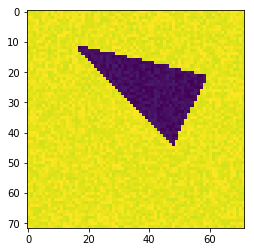

In [22]:
plt.imshow(X_2_)
plt.show()

In [23]:
score = conv_model.evaluate(X_test_2, Y_test_2)
print('Acccuracy of the model on the testing set:', score[1]*100, '%')

300/300 [==============================] - 2s 6ms/step
Acccuracy of the model on the testing set: 85.6666665871938 %


We have pretty good results on the testing dataset. The network has overfitten a little. To get better results, we could for example create a network with a second convolutional layer or train the network with more different data.
(Got 83% of accuracy on the testing set adding one layer).
Convolutional networks are better at detecting moving shapes.

### 6. A Regression Problem

We will predict the position of the vertices of a triangle using a convolutional network

In [24]:
#Let's create the training data
[X_train_r, Y_train_r] = generate_dataset_regression(300, 20)

Creating data:
0
100
200


In [25]:
# Visualization of the data
print(X_train_r[0])
print(Y_train_r[0])
# Y possesses the coordinates of the 3 vertices of the triangel, ordered randomly.

[0.98569204 0.96609374 0.93900169 ... 0.97341692 0.95514528 0.95217142]
[0.71986584 0.92000602 0.31926686 0.97619732 0.56522072 0.02423682]


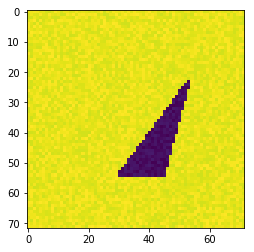

In [26]:
# visualization of the inputs
u = 10
X_r = X_train_r[u].reshape(72, 72)
plt.imshow(X_r)
plt.show()

In [27]:
print('Coordinates of the vertices:', Y_train_r[u])

Coordinates of the vertices: [0.38516997 0.15370283 0.79992748 0.72826283 0.64536412 0.15078903]


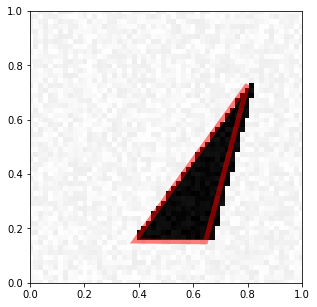

In [28]:
#Visualization of the input and its vertices
visualize_prediction(X_train_r[u], Y_train_r[u])

To help the network to understand what it needs to predict, we will order the vertices on the x axis.

In [29]:
# We try to preprocess the data in order to have an understandable function :we sort the vertices using the x_axis value 
# (vertices_preprocessing) and using the argumetn of the vector [x, y] (vertices_preprocessing_2)
# We finally use this second solution

from cmath import *


def vertices_preprocessing(vertices_list):
    vertices_list = vertices_list.tolist()
    y = [vertices_list[0], vertices_list[2], vertices_list[4]]
    x = [vertices_list[1], vertices_list[3], vertices_list[5]]
    
    x, y = zip(*sorted(zip(y, x)))
    return np.array([x[0], y[0], x[1], y[1], x[2], y[2]])

def vertices_preprocessing_2(vertices_list):
    vertices_list = vertices_list.tolist()
    y = [vertices_list[0], vertices_list[2], vertices_list[4]]
    x = [vertices_list[1], vertices_list[3], vertices_list[5]]
    return_list = []
    
    complex_values = [phase(complex(x[0], y[0])), phase(complex(x[1], y[1])), phase(complex(x[2], y[2]))]
    values_order = [0, 1, 2]
    complex_values, values_order = zip(*sorted(zip(complex_values, values_order)))
    return np.array([y[values_order[0]], x[values_order[0]], y[values_order[1]], x[values_order[1]], y[values_order[2]], x[values_order[2]]])

    
# small test
print(vertices_preprocessing(np.array([5, 1, 2, 3, 3, 2])))
print(vertices_preprocessing_2(np.array([5, 1, 2, 3, 4, 2])))

[2 3 3 2 5 1]
[2 3 4 2 5 1]


In [30]:
for i in range(len(Y_train)):
    Y_train_r[i] = vertices_preprocessing_2(Y_train_r[i])

# print(Y_train_r[0])
X_train_r = X_train_r.reshape(300, 72, 72, 1)

model_r = Sequential()
model_r.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
model_r.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_r.add(Conv2D(64, (5, 5), activation='relu'))
model_r.add(MaxPooling2D(pool_size=(2, 2)))
model_r.add(Flatten())
model_r.add(Dense(200, activation='relu'))
# model.add(Dense(4, activation='relu'))
model_r.add(Dense(6, activation='sigmoid'))
model_r.compile(loss='mse', optimizer='adam', metrics=['mse'])
model_r.fit(X_train_r, Y_train_r, epochs=40)

Epoch 1/40
300/300 [==============================] - 8s 26ms/step - loss: 0.0795 - mean_squared_error: 0.0795
Epoch 2/40
300/300 [==============================] - 7s 24ms/step - loss: 0.0465 - mean_squared_error: 0.0465
Epoch 3/40
300/300 [==============================] - 6s 21ms/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 4/40
300/300 [==============================] - 7s 23ms/step - loss: 0.0261 - mean_squared_error: 0.0261
Epoch 5/40
300/300 [==============================] - 8s 26ms/step - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 6/40
300/300 [==============================] - 7s 24ms/step - loss: 0.0160 - mean_squared_error: 0.0160
Epoch 7/40
300/300 [==============================] - 7s 24ms/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 8/40
300/300 [==============================] - 7s 23ms/step - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 9/40
300/300 [==============================] - 8s 26ms/step - loss: 0.0064 - mean_squared_error: 0.0064
E

First we will see how well the network learned to predict the vertices of the triangles of the training set.

In [31]:
print(model_r.predict(X_train_r[4:5]))
print(Y_train_r[0:1])

[[0.1484289  0.73138857 0.3119203  0.7811176  0.2469234  0.21938154]]
[[0.31926686 0.97619732 0.71986584 0.92000602 0.56522072 0.02423682]]


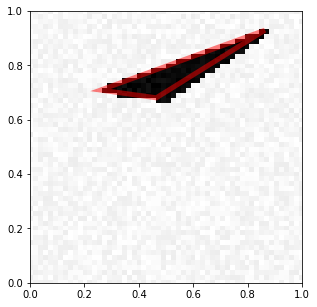

In [32]:
u = 9
visualize_prediction(X_train_r[u:u+1], model_r.predict(X_train_r[u:u+1])[0])

Not too bad. Now we can try to visualize it on a testing set:

In [33]:
[X_test_r, Y_test_r] = generate_dataset_regression(100, 20)
X_test_r = X_test_r.reshape(100, 72, 72, 1)

Creating data:
0


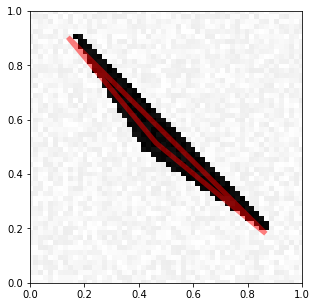

In [35]:
u = 1

visualize_prediction(X_test_r[u:u+1], model_r.predict(X_test_r[u:u+1]))

The algorithm does not work that well. Depending on the triangle, it can be ok or not really good

### 6. Image Denoising

We will try to create a neural networks that denoises an image.
First I recreate the functions used to define the different shapes. Basically each function will return two arrays, one is the noisy image and the othe the not-noisy image.

In [16]:
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)]


def generate_a_disk_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)]

def generate_a_triangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return [generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)]


def generate_dataset_denoising(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_denoising()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            noise = float(np.random.random(1)*200)
            X_ = generate_a_rectangle_denoising(noise, free_location)
            X[i] = X_[0]
            Y[i] = X_[1]
        elif category == 1: 
            noise = float(np.random.random(1)*200)
            X_ = generate_a_disk_denoising(noise, free_location) 
            X[i] = X_[0]
            Y[i] = X_[1]
        else:
            noise = float(np.random.random(1)*200)
            X_ = generate_a_triangle_denoising(noise, free_location)
            X[i] = X_[0]
            Y[i] = X_[1]
    X = 1 - ((X + noise) / (255 + 2 * noise))
    Y = 1 - (Y / 255)
    return [X, Y]

def generate_test_set_denoising():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, True)
    return [X_test, Y_test]

In [17]:
# Creation of the training dataset
[X_train_d, Y_train_d] = generate_dataset_denoising(100)

Creating data:
0


In [18]:
print(X_train_d[0])
print(Y_train_d[0])

[ 0.11981555  0.14360166 -0.30119396 ...  0.14332348 -0.16721555
 -0.31252523]
[0. 0. 0. ... 0. 0. 0.]


[[ 0.13630814 -0.1951335  -0.25993703 ... -0.32861342 -0.29954911
  -0.23438833]
 [-0.2331782  -0.16665968 -0.07483387 ... -0.22704001 -0.31136822
  -0.02570234]
 [-0.04314329 -0.09155153 -0.36801619 ... -0.03560145 -0.02798041
  -0.28522335]
 ...
 [-0.07961909  0.04903938 -0.06917124 ... -0.27095655  0.02732249
  -0.30111594]
 [-0.20459778 -0.29893835  0.03581582 ... -0.20410304 -0.19577715
   0.01278548]
 [-0.05865476  0.04191448  0.12989519 ...  0.10850876  0.11190694
  -0.08842448]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


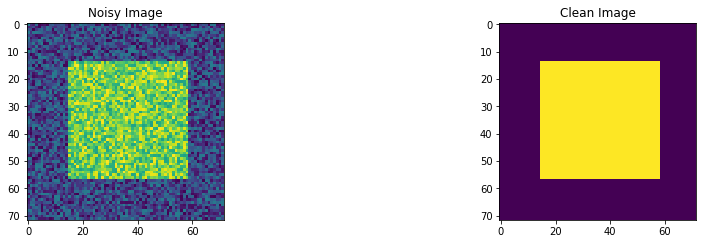

In [19]:
# Visualization of the data
u = 10
X_d = X_train_d[u].reshape(72, 72)
print(X_d)

X_d_n = Y_train_d[u].reshape(72, 72)
print(X_d_n)

plt.subplots(2, 1, figsize=(12, 12))

plt.subplot(131)
plt.title('Noisy Image')
plt.imshow(X_d)

plt.subplot(133)
plt.title('Clean Image')
plt.imshow(X_d_n)

plt.show()

In [20]:
from keras.layers import Input, UpSampling2D
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D


X_train_d = X_train_d.reshape(100, 72, 72, 1)
Y_train_d = Y_train_d.reshape(100, 72, 72, 1)

input_shape = (72, 72, 1)

input_img = Input(shape=(72, 72, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(64, (5, 5), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(input_img, decoded)
decoder.compile(optimizer='adadelta', loss='binary_crossentropy')

decoder.fit(X_train_d, Y_train_d, epochs=100, batch_size=1)

Epoch 1/100
100/100 [==============================] - 10s 103ms/step - loss: 0.2266
Epoch 2/100
100/100 [==============================] - 8s 83ms/step - loss: 0.0427
Epoch 3/100
100/100 [==============================] - 9s 86ms/step - loss: 0.0272
Epoch 4/100
100/100 [==============================] - 9s 88ms/step - loss: 0.0197
Epoch 5/100
100/100 [==============================] - 9s 93ms/step - loss: 0.0148
Epoch 6/100
100/100 [==============================] - 9s 90ms/step - loss: 0.0111
Epoch 7/100
100/100 [==============================] - 9s 90ms/step - loss: 0.0092
Epoch 8/100
100/100 [==============================] - 8s 81ms/step - loss: 0.0082
Epoch 9/100
100/100 [==============================] - 9s 94ms/step - loss: 0.0073
Epoch 10/100
100/100 [==============================] - 10s 98ms/step - loss: 0.0068
Epoch 11/100
100/100 [==============================] - 11s 112ms/step - loss: 0.0047
Epoch 12/100
100/100 [==============================] - 11s 111ms/step - loss: 0

We can now visualize the results on the training set

In [22]:
image_to_test = 2

print(X_train_d.shape)
y = decoder.predict(X_train_d[image_to_test:image_to_test+1])

(100, 72, 72, 1)


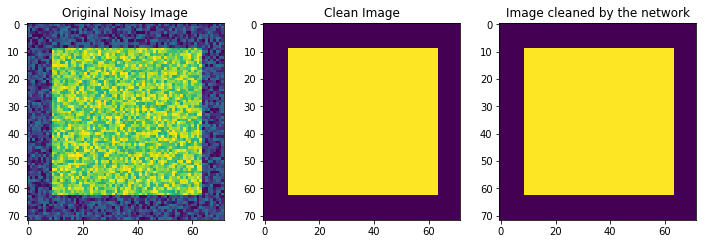

In [23]:
y = y.reshape(72, 72)
x = Y_train_d[image_to_test:image_to_test+1].reshape(72, 72)
x_n = X_train_d[image_to_test:image_to_test+1].reshape(72, 72)

plt.subplots(3, 1, figsize=(12, 12))

plt.subplot(131)
plt.title('Original Noisy Image')
plt.imshow(x_n)

plt.subplot(132)
plt.title('Clean Image')
plt.imshow(x)

plt.subplot(133)
plt.title('Image cleaned by the network')
plt.imshow(y)

plt.show()


Now we can see how well it works on testing data.

In [24]:
[X_test_d, Y_test_d] = generate_test_set_denoising()
X_test_d = X_test_d.reshape(300, 72, 72, 1)
print(Y_test_d.shape)

Creating data:
0
100
200
(300, 5184)


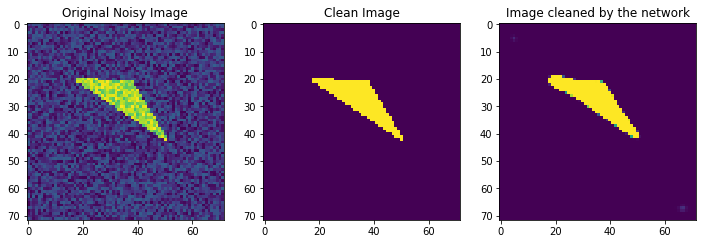

In [25]:
image_to_test = 8
y = decoder.predict(X_test_d[image_to_test:image_to_test+1]).reshape(72, 72)

x = X_test_d[image_to_test:image_to_test+1].reshape(72, 72)

z = Y_test_d[image_to_test:image_to_test+1].reshape(72, 72)

plt.subplots(3, 1, figsize=(12, 12))

plt.subplot(131)
plt.title('Original Noisy Image')
plt.imshow(x)

plt.subplot(132)
plt.title('Clean Image')
plt.imshow(z)

plt.subplot(133)
plt.title('Image cleaned by the network')
plt.imshow(y)

plt.show()

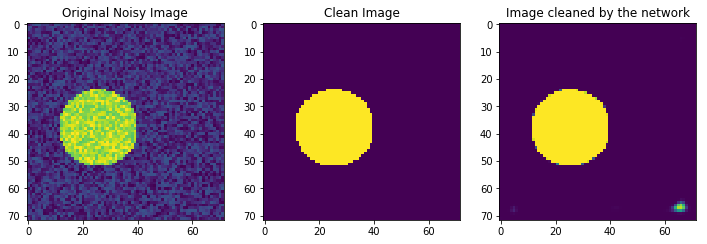

In [28]:
image_to_test = 4

y = decoder.predict(X_test_d[image_to_test:image_to_test+1]).reshape(72, 72)

x = X_test_d[image_to_test:image_to_test+1].reshape(72, 72)

z = Y_test_d[image_to_test:image_to_test+1].reshape(72, 72)

plt.subplots(3, 1, figsize=(12, 12))

plt.subplot(131)
plt.title('Original Noisy Image')
plt.imshow(x)

plt.subplot(132)
plt.title('Clean Image')
plt.imshow(z)

plt.subplot(133)
plt.title('Image cleaned by the network')
plt.imshow(y)

plt.show()

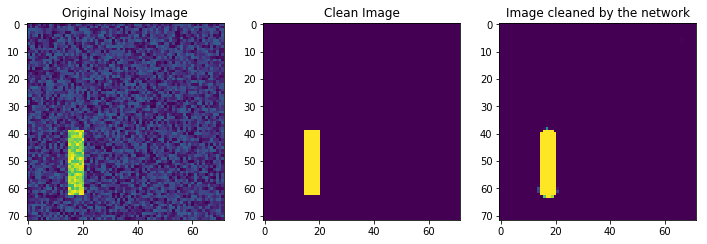

In [31]:
image_to_test = 7

y = decoder.predict(X_test_d[image_to_test:image_to_test+1]).reshape(72, 72)

x = X_test_d[image_to_test:image_to_test+1].reshape(72, 72)

z = Y_test_d[image_to_test:image_to_test+1].reshape(72, 72)

plt.subplots(3, 1, figsize=(12, 12))

plt.subplot(131)
plt.title('Original Noisy Image')
plt.imshow(x)

plt.subplot(132)
plt.title('Clean Image')
plt.imshow(z)

plt.subplot(133)
plt.title('Image cleaned by the network')
plt.imshow(y)

plt.show()

Results are pretty good. However we can see that near the border, some pixels are not compltetly perfect.
We could imagine that using more complicated images, the results would be less good. 